# Workflow

En esta práctica vamos a aplicar lo aprendido en esta asignatura para crear un flujo que automatice la descarga, análisis y publicación de los datos utilizando distintas herramientas como Zenodo, GitHub y librerías de Python para el análisis de datos.

### Librerías necesarias para la práctica

```python
import xml.etree.ElementTree as ET
import requests
import json
import zipfile
```

### Elementos necesarios
* Al menos un fichero CSV
* Un script de análisis de datos en CSV (Publicado en GitHub)

In [1]:
import xml.etree.ElementTree as ET
import requests
import json
import zipfile

# Publicación de datos iniciales

Utilizando Zenodo, de forma manual, publicar los datos que se vayan a utilizar.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Utilizar Communities para localizar más facilmente los datos</p>
</div>


Tomamos datos de Eurostat sobre tasas de empleo empleo en Europa.  
La tabla actualizada se puede encontrar navegando por el árbol de datos de la [web de Eurostat](https://ec.europa.eu/eurostat/data/database):
```   
   Data navigation tree
     Database by themes
       Population and social conditions
         Labour market(labour)
           Employment and unemployment(Labour force survey)(employ)
             LFS series - detailed quarterly survey results(from 1998 onwards)(lfsq)
               Employment rates - LFS series(lfsq_emprt)
                 Employment rates by sex, age and educational attainment level (%) (lfsq_ergaed)
```

Los datos se presentan agrupados por cuatrimestre, y están agregados por país, sexo, edad y nivel de educación:
- **Países:** BE, BG, CZ, DK, DE, EE, IE, EL, ES, FR, HR, IT, CY, LV, LT, LU, HU, MT, NL, AT, PL, PT, RO, SI, SK, FI, SE, UK, IS, NO, CH, ME, MK, RS, TR. Grupos de países: EU28, EU27, EU15, EA19, EA18, EA17.

- **Sexo:** Female, male.
- **Edad:** Todos los posibles intervalos de edad $[a, b]$ con $a\in \{15, 19, 24, 39, 59, 64\}$ y $b\in \{19, 24, 39, 59, 64, 74\}$.
- **Nivel de educación:** 
  - TOTAL: All ISCED 2011 levels.
  - ED0-2: Less than primary, primary and lower secondary education (levels 0-2).
  - ED3_4: Upper secondary and post-secondary non-tertiary education (levels 3 and 4).
  - ED5-8: Tertiary education (levels 5-8).
  - NRP: No response.
  
Descargamos la tabla (que incluye desde el primer cuatrimestre de 1998 hasta el tercer cuatrimestre de 2018), y la subimos a la comunidad de Zenodo [iipr's Datasets for Data Science](https://zenodo.org/communities/iipr_dlc_unican/). El DOI asignado es https://doi.org/10.5281/zenodo.2541848

# Publicación de script de análisis

En GitHub + Zenodo

Creamos un repositorio público en GitHub https://github.com/iipr-Master-Data-Science/dlc_zenodo_integration  
En él, añadimos un script de Python que toma datos de una tabla del estilo de la que acabamos de describir y genera, para ciertos países, y un cierto rango de edad, dos histogramas horizontales enfrentados que compara los datos correspondientes para mujeres y hombres, agrupando los cuatrimestres en años.

Integramos este repositorio con Zenodo para que cada nueva release se publique automáticamente en Zenodo con su correspondiente DOI. La última está en https://zenodo.org/record/2554373

**Nota:** Ya que el respositorio que he usado no se encuentra en mi cuenta pública de GitHub si no en un organización creada por mi, tuve que dar permiso a Zenodo de manera manual para que pudiera acceder a la información de esta organización y así ver los repositorios contenidos en ella.

# Descarga de datos

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

Pista: url+'?verb=ListRecords&set=nombre_set

https://zenodo.org/record/2541848

## Get metadata formats:

In [2]:
def get_oai_metadata_formats(url):
    """Lists the available metadata formats.
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        Returns
        -------
        metadata_formats : 
            Name of the downloaded file(s).
    """
    metadata_formats = []
    oai_verb = '?verb=ListMetadataFormats'
    oai = requests.get(url + oai_verb) #Peticion al servidor
    xmlTree = ET.ElementTree(ET.fromstring(oai.text))
    iterator = xmlTree.iter()
    for elem in iterator:
        if (elem.tag == '{http://www.openarchives.org/OAI/2.0/}metadataPrefix'):
            metadata_formats.append(elem.text)
    return metadata_formats

In [3]:
oai_url = 'https://zenodo.org/oai2d'
get_oai_metadata_formats(oai_url)

['marcxml',
 'oai_dc',
 'oai_datacite',
 'marc21',
 'datacite',
 'datacite3',
 'datacite4',
 'oai_datacite3']

## Search dataset

In [4]:
def search_dataset(url, oai_set, metadata_format):
    """Search the datasets identifiers in the defined set.
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        oai_set : string
            OAI-PMH set where the datasets will be searched
        metadata_format : string
            Selected metadata format to search
        Returns
        -------
        dataset_ids : array 
            Dataset IDs
    """
    #Define bounds to search in specific set
    bounds = "&set=" + oai_set
    oai = requests.get(url + '?verb=ListRecords' + bounds + '&metadataPrefix=' + metadata_format)
    namespaces = {'oai': 'http://www.openarchives.org/OAI/2.0/'}
    xmlTree = ET.fromstring(oai.text)
    item = xmlTree.findall('.//oai:identifier', namespaces)
    return item

In [5]:
# Para encontrar el dataset, usamos la comunidad creada
oai_set = 'user-iipr_dlc_unican'
id_list = search_dataset(oai_url, oai_set,'oai_dc')
id_list[0].text

'oai:zenodo.org:2541848'

## Get record

In [6]:
def get_records(ids, fnames):
    """Download list of resources.
        Parameters
        ----------
        ids : array
            List of dataset ids
        fnames : array
            List of output file names
    """
    headers = {'accept': 'application/json'}
    for i, id_curr in enumerate(ids):
        id_curr = id_curr.text.split(':')[-1]
        r = requests.get('https://zenodo.org/api/records/{}'.format(id_curr), headers)
        record = json.loads(r.text)
        data_url = record['files'][0]['links']['self']
        with open(fnames[i], 'wb') as f:
            f.write(requests.get(data_url).content)
            print('Data saved in {}'.format(fnames[i]))
    return

In [7]:
fnames = ['lfsq_ergaed.tsv.gz']
get_records(id_list[0:1], fnames)

Data saved in lfsq_ergaed.tsv.gz


También descomprimimos:

In [8]:
!gunzip lfsq_ergaed.tsv.gz

In [9]:
!ls -la

total 15880
drwxr-xr-x  10 iker  staff      340  1 feb 19:30 .
drwxr-xr-x  11 iker  staff      374 31 ene 19:39 ..
-rw-r--r--@  1 iker  staff     6148  1 feb 19:26 .DS_Store
drwxr-xr-x  15 iker  staff      510  1 feb 15:37 .git
-rw-r--r--   1 iker  staff     1976 17 ene 11:43 .gitignore
drwxr-xr-x   4 iker  staff      136 31 ene 18:21 .ipynb_checkpoints
-rw-r--r--   1 iker  staff   110631  1 feb 19:29 M3.02Workflow.ipynb
-rw-r--r--@  1 iker  staff    92962 31 ene 18:21 M3.02Workflow_resuelto.ipynb
-rw-r--r--   1 iker  staff       18 17 ene 11:43 README.md
-rw-r--r--   1 iker  staff  7901493  1 feb 19:30 lfsq_ergaed.tsv


# Descarga de código

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Zenodo guarda un zip con el código</p>
</div>

- Repositorio: https://github.com/iipr-Master-Data-Science/dlc_zenodo_integration/
- Release en Zenodo: http://doi.org/10.5281/zenodo.2554373

Get Record:

In [10]:
verb = '?verb=GetRecord'
comm = '&metadataPrefix=oai_dc&identifier=oai:zenodo.org:2554373'
oai = requests.get(oai_url + verb + comm)
xmlTree = ET.fromstring(oai.text)
iterator = xmlTree.iter()
for elem in iterator:
    print(elem.tag + ': ' + elem.text)

{http://www.openarchives.org/OAI/2.0/}OAI-PMH: 
  
{http://www.openarchives.org/OAI/2.0/}responseDate: 2019-02-01T18:30:18Z
{http://www.openarchives.org/OAI/2.0/}request: https://zenodo.org/oai2d
{http://www.openarchives.org/OAI/2.0/}GetRecord: 
    
{http://www.openarchives.org/OAI/2.0/}record: 
      
{http://www.openarchives.org/OAI/2.0/}header: 
        
{http://www.openarchives.org/OAI/2.0/}identifier: oai:zenodo.org:2554373
{http://www.openarchives.org/OAI/2.0/}datestamp: 2019-02-01T01:32:49Z
{http://www.openarchives.org/OAI/2.0/}setSpec: software
{http://www.openarchives.org/OAI/2.0/}setSpec: user-iipr_dlc_unican
{http://www.openarchives.org/OAI/2.0/}metadata: 
        
{http://www.openarchives.org/OAI/2.0/oai_dc/}dc: 
          
{http://purl.org/dc/elements/1.1/}creator: Ignacio Iker Prado Rujas
{http://purl.org/dc/elements/1.1/}date: 2019-01-31
{http://purl.org/dc/elements/1.1/}description: In this new release we have improved the code, allowing to call the script with several

In [14]:
# Para encontrar el dataset, usamos la comunidad creada
oai_set = 'user-iipr_dlc_unican'
id_list = search_dataset(oai_url, oai_set,'oai_dc')
id_list[3].text

'oai:zenodo.org:2554373'

In [15]:
fnames = ['dlc_zenodo_integration-v1.0.zip']
get_records(id_list[3:4], fnames)

Data saved in dlc_zenodo_integration-v1.0.zip


Decomprimimos:

In [16]:
!unzip dlc_zenodo_integration-v1.0.zip

Archive:  dlc_zenodo_integration-v1.0.zip
1740440de8258acf72774d23bb2585ce9df6b581
   creating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/.gitignore  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/LICENSE  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/README.md  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/make_plots.py  
   creating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/DE_ES_EU28_Y15-24_TOTAL.svg  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/PL_LT_HU_Y25-64_ED3_4.svg  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/UK_NL_IT_Y25-64_ED5-8.svg  


# Análisis de los datos

Producir fichero: Otro CSV, imagen, etc

3.7.0 (default, Oct  2 2018, 09:19:48) 
[Clang 9.0.0 (clang-900.0.39.2)]
Sexs: ['F' 'M' 'T']
Geos: ['AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EA17' 'EA18' 'EA19' 'EE' 'EL'
 'ES' 'EU15' 'EU27' 'EU28' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU'
 'LV' 'ME' 'MK' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE' 'SI' 'SK' 'TR'
 'UK']
Age ranges: ['Y15-19' 'Y15-24' 'Y15-39' 'Y15-59' 'Y15-64' 'Y15-74' 'Y20-24' 'Y20-64'
 'Y25-29' 'Y25-49' 'Y25-54' 'Y25-59' 'Y25-64' 'Y25-74' 'Y30-34' 'Y35-39'
 'Y40-44' 'Y40-59' 'Y40-64' 'Y45-49' 'Y50-54' 'Y50-59' 'Y50-64' 'Y50-74'
 'Y55-59' 'Y55-64' 'Y60-64' 'Y65-69' 'Y65-74' 'Y70-74']
Educational levels: ['ED0-2' 'ED3_4' 'ED5-8' 'NRP' 'TOTAL']


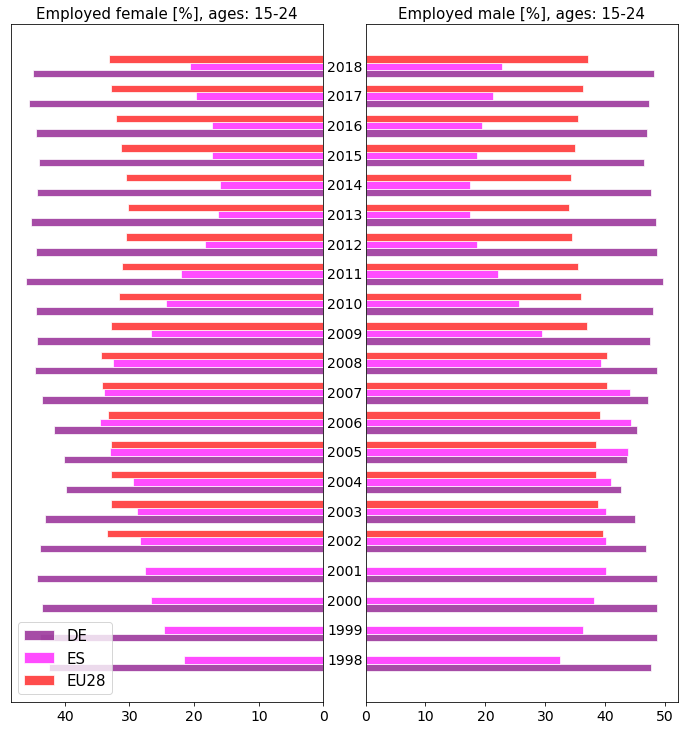

In [18]:
%run -i iipr-Master-Data-Science-dlc_zenodo_integration-1740440/make_plots.py lfsq_ergaed.tsv DE ES EU28 Y15-24 TOTAL

Por cómo hemos realizado el script que genera el gráfico, es sencillo llamar múltiples veces al script para generar gráficos diferentes:

3.7.0 (default, Oct  2 2018, 09:19:48) 
[Clang 9.0.0 (clang-900.0.39.2)]
Sexs: ['F' 'M' 'T']
Geos: ['AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EA17' 'EA18' 'EA19' 'EE' 'EL'
 'ES' 'EU15' 'EU27' 'EU28' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU'
 'LV' 'ME' 'MK' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE' 'SI' 'SK' 'TR'
 'UK']
Age ranges: ['Y15-19' 'Y15-24' 'Y15-39' 'Y15-59' 'Y15-64' 'Y15-74' 'Y20-24' 'Y20-64'
 'Y25-29' 'Y25-49' 'Y25-54' 'Y25-59' 'Y25-64' 'Y25-74' 'Y30-34' 'Y35-39'
 'Y40-44' 'Y40-59' 'Y40-64' 'Y45-49' 'Y50-54' 'Y50-59' 'Y50-64' 'Y50-74'
 'Y55-59' 'Y55-64' 'Y60-64' 'Y65-69' 'Y65-74' 'Y70-74']
Educational levels: ['ED0-2' 'ED3_4' 'ED5-8' 'NRP' 'TOTAL']


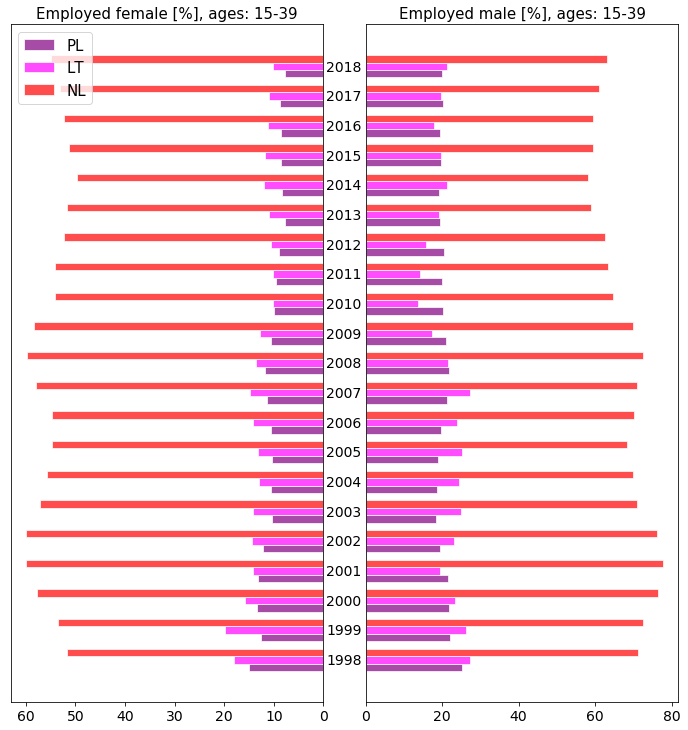

In [19]:
%run -i iipr-Master-Data-Science-dlc_zenodo_integration-1740440/make_plots.py lfsq_ergaed.tsv PL LT NL Y15-39 ED0-2

# Publicación de los Datos

Utilizando la API de Zenodo

Basándonos en [este link](https://developers.zenodo.org/), definimos nuestro token de acceso:

In [20]:
ACCESS_TOKEN = 'xxx'

1. Try to access the API:

In [21]:
r = requests.get("https://zenodo.org/api/deposit/depositions",
                 params={'access_token': ACCESS_TOKEN})
print(r.status_code)
r.json()[1]['metadata']['creators'][0]

200


{'affiliation': 'user-iipr_dlc_unican', 'name': 'Ignacio Iker Prado Rujas'}

2. Next, let’s create a new empty upload:

In [77]:
headers = {"Content-Type": "application/json"}
r = requests.post('https://zenodo.org/api/deposit/depositions',
                  params={'access_token': ACCESS_TOKEN}, json={},
                  headers=headers)
print(r.status_code)
r.json()

201


{'conceptrecid': '2555267',
 'created': '2019-02-01T18:14:05.331551+00:00',
 'files': [],
 'id': 2555268,
 'links': {'bucket': 'https://zenodo.org/api/files/5c95a118-fba6-4d0b-a521-ca0db95bd65e',
  'discard': 'https://zenodo.org/api/deposit/depositions/2555268/actions/discard',
  'edit': 'https://zenodo.org/api/deposit/depositions/2555268/actions/edit',
  'files': 'https://zenodo.org/api/deposit/depositions/2555268/files',
  'html': 'https://zenodo.org/deposit/2555268',
  'latest_draft': 'https://zenodo.org/api/deposit/depositions/2555268',
  'latest_draft_html': 'https://zenodo.org/deposit/depositions/2555268',
  'publish': 'https://zenodo.org/api/deposit/depositions/2555268/actions/publish',
  'self': 'https://zenodo.org/api/deposit/depositions/2555268'},
 'metadata': {'prereserve_doi': {'doi': '10.5281/zenodo.2555268',
   'recid': 2555268}},
 'modified': '2019-02-01T18:14:05.331560+00:00',
 'owner': 58450,
 'record_id': 2555268,
 'state': 'unsubmitted',
 'submitted': False,
 'title'

3. Now, let’s upload a new file:

**Nota:** Aquí quise subir los dos `.svg` directamente, pero no era capaz de abrilos como `bytes` y así añadirlo a la subida. Por tanto creé un `.zip` con ellos.

In [78]:
# Get the deposition id from the previous response
deposition_id = r.json()['id']
data = {'graphs': 'graphs.zip'}
files = {'file': open('graphs.zip', 'rb')}
r = requests.post('https://zenodo.org/api/deposit/depositions/%s/files' % deposition_id,
                  params={'access_token': ACCESS_TOKEN}, data=data,
                  files=files)
print(r.status_code)
r.json()

201


{'checksum': '8bd6f717d3aa6768e50d29ef9d08697c',
 'filename': 'graphs.zip',
 'filesize': 23032,
 'id': '653cbe64-8849-4bc3-b45e-868c71edfa90',
 'links': {'download': 'https://zenodo.org/api/files/5c95a118-fba6-4d0b-a521-ca0db95bd65e/graphs.zip',
  'self': 'https://zenodo.org/api/deposit/depositions/2555268/files/653cbe64-8849-4bc3-b45e-868c71edfa90'}}

4. Add some metadata:

**Nota:** [Aquí](https://developers.zenodo.org/#representation) aparece cómo agregar metadatos (lo que hicimos al principio de manera manual desde Zenodo, pero programáticamente). Aunque es completo, se agradecería algún ejemplo más sobre, por ejemplo, cómo añadir la comunidad o el tipo de plot de los datos subidos.

In [89]:
data = {
    'metadata': {
        'title': 'Unemployment rates graphs',
        'upload_type': 'image', 
        'image_type' : 'plot',
        'description': 'Test to publish content on Zenodo',
        'creators': [{'name': 'Ignacio Iker Prado Rujas'}],
        'communities': [{'identifier': 'iipr_dlc_unican'}],
    }
}
r = requests.put('https://zenodo.org/api/deposit/depositions/%s' % deposition_id,
                 params={'access_token': ACCESS_TOKEN}, data=json.dumps(data),
                 headers=headers)
r.status_code
r.json()

{'conceptrecid': '2555267',
 'created': '2019-02-01T18:14:05.331551+00:00',
 'files': [{'checksum': '8bd6f717d3aa6768e50d29ef9d08697c',
   'filename': 'graphs.zip',
   'filesize': 23032,
   'id': '653cbe64-8849-4bc3-b45e-868c71edfa90',
   'links': {'download': 'https://zenodo.org/api/files/5c95a118-fba6-4d0b-a521-ca0db95bd65e/graphs.zip',
    'self': 'https://zenodo.org/api/deposit/depositions/2547307/files/653cbe64-8849-4bc3-b45e-868c71edfa90'}}],
 'id': 2555268,
 'links': {'bucket': 'https://zenodo.org/api/files/5c95a118-fba6-4d0b-a521-ca0db95bd65e',
  'discard': 'https://zenodo.org/api/deposit/depositions/2555268/actions/discard',
  'edit': 'https://zenodo.org/api/deposit/depositions/2555268/actions/edit',
  'files': 'https://zenodo.org/api/deposit/depositions/2555268/files',
  'html': 'https://zenodo.org/deposit/2555268',
  'latest_draft': 'https://zenodo.org/api/deposit/depositions/2555268',
  'latest_draft_html': 'https://zenodo.org/deposit/depositions/2555268',
  'newversion': '

4. And we’re ready to publish:

In [90]:
r = requests.post('https://zenodo.org/api/deposit/depositions/%s/actions/publish' % deposition_id,
                      params={'access_token': ACCESS_TOKEN} )
print(r.status_code)
r.json()

202


{'conceptdoi': '10.5281/zenodo.2555267',
 'conceptrecid': '2555267',
 'created': '2019-02-01T18:14:05.331551+00:00',
 'doi': '10.5281/zenodo.2555268',
 'doi_url': 'https://doi.org/10.5281/zenodo.2555268',
 'files': [{'checksum': '8bd6f717d3aa6768e50d29ef9d08697c',
   'filename': 'graphs.zip',
   'filesize': 23032,
   'id': '653cbe64-8849-4bc3-b45e-868c71edfa90',
   'links': {'download': 'https://zenodo.org/api/files/5c95a118-fba6-4d0b-a521-ca0db95bd65e/graphs.zip',
    'self': 'https://zenodo.org/api/deposit/depositions/2553541/files/653cbe64-8849-4bc3-b45e-868c71edfa90'}}],
 'id': 2555268,
 'links': {'badge': 'https://zenodo.org/badge/doi/10.5281/zenodo.2555268.svg',
  'bucket': 'https://zenodo.org/api/files/5c95a118-fba6-4d0b-a521-ca0db95bd65e',
  'conceptbadge': 'https://zenodo.org/badge/doi/10.5281/zenodo.2555267.svg',
  'conceptdoi': 'https://doi.org/10.5281/zenodo.2555267',
  'doi': 'https://doi.org/10.5281/zenodo.2555268',
  'latest': 'https://zenodo.org/api/records/2555268',
  

Comprobamos que se ha subido correctamente:

In [27]:
verb = '?verb=GetRecord'
comm = '&metadataPrefix=oai_dc&identifier=oai:zenodo.org:2555268'
oai = requests.get(oai_url + verb + comm)
xmlTree = ET.fromstring(oai.text)
namespaces = {'dc': 'http://purl.org/dc/elements/1.1/'}
item = xmlTree.findall('.//dc:description', namespaces)
for elem in item:
    print(elem.tag + ': ' + elem.text)

{http://purl.org/dc/elements/1.1/}description: Test to publish content on Zenodo


¿Puedes replicar ese workflow en un sólo bloque con otros datos?

Como ejercicio, se podría buscar otro dataset con la misma estructura (que los hay) en la web de Eurostat, y sería sencillo agrupar lo hecho en este notebook en una única llamada o incluso en un módulo de Python. También se podría automatizar la generación de muchos gráficos comparativos como los anteriores y su publicación ordenada en Zenodo.